
# TP Image classification of MNIST (reduced)
## using correlation filters, kNN and/or logistic regression
### Diane LINGRAND 

diane.lingrand@univ-cotedazur.fr   
Polytech SI3  2022-2023

In [4]:
from IPython.display import Image
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay

from tqdm import tqdm

import wget

import pickle

## Data loading

Before executing the next cell, you need to have downloaded the files in the current directory or to change the paths in the next cell.

In [5]:
import pickle

URLS = [
    "https://www.i3s.unice.fr/~lingrand/redMNIST-x-train.bin",
    "https://www.i3s.unice.fr/~lingrand/redMNIST-x-test.bin",
    "https://www.i3s.unice.fr/~lingrand/redMNIST-y-train.bin",
    "https://www.i3s.unice.fr/~lingrand/redMNIST-y-test.bin"
]

# Download the files to data/
import os
if not os.path.exists("data"):
    os.mkdir("data")

for url in URLS:
    wget.download(url, out="data/")

with open('data/redMNIST-x-train.bin', 'rb') as input:
    xTrain = pickle.load(input)
with open('data/redMNIST-x-test.bin', 'rb') as input:
    xTest = pickle.load(input)
with open('data/redMNIST-y-test.bin', 'rb') as input:
    yTest = pickle.load(input)
with open('data/redMNIST-y-train.bin', 'rb') as input:
    yTrain = pickle.load(input)
yTrain = np.array(yTrain)
yTest = np.array(yTest)

**Question 1:** What are the dimensions of train data and test data?

In [6]:
print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)

(2000, 28, 28)
(1000, 28, 28)
(2000,)
(1000,)


**Question 2:** How many classes?

In [7]:
print(len(np.unique(yTrain)))
print(len(np.unique(yTest)))

10
10


**Question 3:** What are the minimal and maximal values of pixels in those images?

In [8]:
print (np.min(xTrain), np.max(xTrain))

0.0 1.0


Let's visualize an image from the training dataset:

4


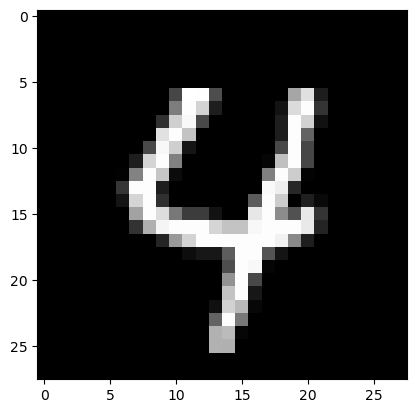

In [9]:
import random
n = random.randrange(0,len(yTrain))
plt.imshow(xTrain[n], cmap=plt.cm.gray)
print(yTrain[n])

## Baseline: raw MNIST data without correlations

We first need to flatten the data:

In [10]:
x_train = xTrain.reshape(len(yTrain),784)
x_test = xTest.reshape(len(yTest),784)

The baseline is obtained using a kNN classification with k=10 on the raw MNIST dataset. 

**Question 4:** Compute the evaluation metrics (accuracy, F1 score and confusion matrix) using the test set. Publish the accuracy in slack as the variable <font color='red'>rawKnn10</font>.

Accuracy: 0.866
F1: 0.866
Score: 0.866


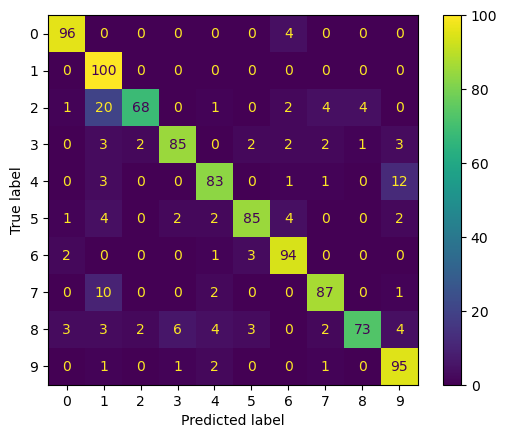

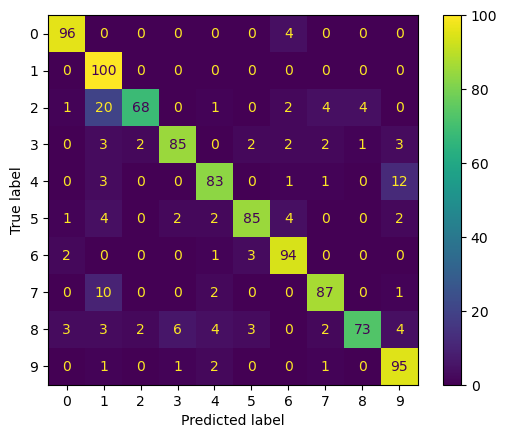

In [11]:
def kNN(k, x_train, y_train, x_test, y_test):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    return {
        "f1": f1_score(y_test, y_pred, average="micro"),
        "accuracy": accuracy_score(y_test, y_pred),
        "score": classifier.score(x_test, y_test),
        "y_pred": y_pred,
    }

NN10 = kNN(10, x_train, yTrain, x_test, yTest)

print(f"Accuracy: {NN10['accuracy']}")
print(f"F1: {NN10['f1']}")
print(f"Score: {NN10['score']}")

ConfusionMatrixDisplay.from_predictions(yTest, NN10["y_pred"]).plot()



**Question 5:** Find the best k value for the previous question. Publish the best k value as <font color='red'>rawKnnBestK</font> and the best accuracy as <font color='red'>rawKnnBestAcc</font>.

In [12]:
res = [kNN(k, x_train, yTrain, x_test, yTest) for k in range(1, 20)]
res_acuracy = [x["score"] for x in res]
max_k = np.argmax(res_acuracy)

print(f"best k = {max_k+1} with acuracy = {res_acuracy[max_k]}")

nn_res = res[max_k]


best k = 3 with acuracy = 0.88


**Question 5:** Learn a logistic regression on the train set and compute the metrics on the test set. Be aware that the default maximal number of iterations may need to be adapted. Publish the accuracy as <font color='red'>rawLogReg</font>.

Accuracy: 0.861
F1: 0.861
Score: 0.861


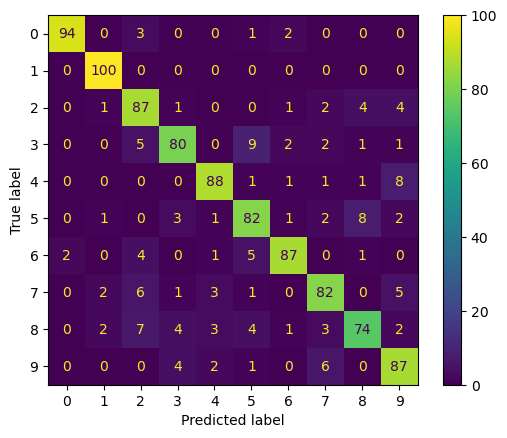

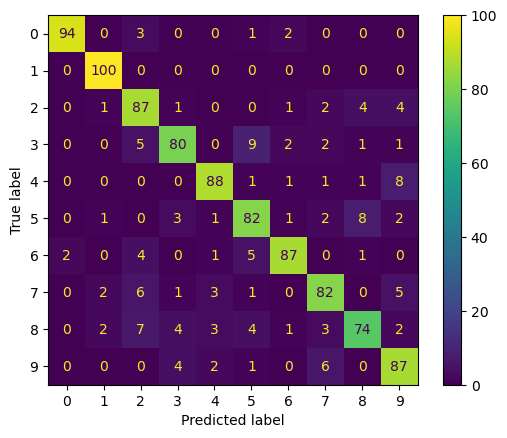

In [13]:
def linear_regression(x_train, y_train, x_test, y_test):
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    return {
        "f1": f1_score(y_test, y_pred, average="micro"),
        "accuracy": accuracy_score(y_test, y_pred),
        "score": classifier.score(x_test, y_test),
        "y_pred": y_pred,
    }

lr_res = linear_regression(x_train, yTrain, x_test, yTest)
print(f"Accuracy: {lr_res['accuracy']}")
print(f"F1: {lr_res['f1']}")
print(f"Score: {lr_res['score']}")
ConfusionMatrixDisplay.from_predictions(yTest, lr_res["y_pred"]).plot()

**Question 6:** Up to now, what is the best method?

In [14]:
delta = round(lr_res["score"] - nn_res["score"], 3)
if delta > 0:
    print(f"Linear regression is better by {delta}")
else:
    print(f"KNN is better by {-delta}")


KNN is better by 0.019


## Correlation kernels and functions

We propose 2 sets of kernel denoted by variables 'c3x3' and 'c5x5'. Feel free to imagine other sets of kernels.

In [15]:
# 4 kernels of dim 3x4
c0 = np.array([[-1.1, -1.49, -0.72],
 [-0.78,  0.8,   0.92],
 [ 1.58,  0.73,  0.62]])
c1 = np.array([[ 1.22, 0.97,  0.39],
 [-0.62,  0.92,  1.42],
 [-1.55, -1.65, -0.51]])
c2 = np.array([[ 0.48, 1.32, -1.08],
 [ 0.98,  0.69, -1.99],
 [ 1.35, -0.24, -1.59]])
c3 = np.array([[-0.38,  1.03,  1.28],
 [-1.37,  0.18,  0.24],
 [-0.1,   0.9,   1.29]])
c3x3 = np.array([c0,c1,c2,c3])

In [16]:
# 8 kernels of dim 5x5
c0 = np.array([[-0.05, -0.13,  0.02,  0.12,  0.12],
 [-0.23,  0.45,  0.86,  0.79,  0.35],
 [-0.04,  0.35,  0.58,  0.41, -0.4 ],
 [-0.09,  0.12,  0.2 ,  0.22, -0.6 ],
 [ 0.31,  0.07, -0.01, -0.38, -0.19]])
c1 = np.array([[ 0.27,  0.1 ,  0.36,  0.29,  0.65],
 [ 0.34,  0.54,  0.62,  0.43,  0.76],
 [ 0.66,  0.64,  0.57,  0.15, -0.06],
 [ 0.25,  0.29, -0.01, -0.14, -0.84],
 [-1.23, -1.59, -1.78, -1.04, -1.07]])
c2 = np.array([[-0.66, -0.87, -1.09, -1.25, -0.44],
 [-0.01,  0.18, -0.06,  0.11,  0.13],
 [ 0.39,  0.5 ,  0.51,  0.42,  0.32],
 [ 0.32,  0.49,  0.3 ,  0.35,  0.41],
 [ 0.64,  0.7 ,  0.22, -0.05,  0.28]])
c3 = np.array([[ 1.01,  0.07,  0.16, -0.42, -0.75],
 [ 0.23,  0.08,  0.3 ,  0.11, -0.14],
 [-0.69,  0.02,  0.19,  0.35,  0.16],
 [-0.74,  0.45,  0.61,  0.26, -0.04],
 [ 0.1,   0.6 ,  0.15, -0.37, -0.84]])
c4 = np.array([[ 0.25,  0.34,  0.29, -0.42, -0.69],
 [ 0.5,   0.31,  0.45, -0.34, -0.31],
 [ 0.66,  0.6 ,  0.28, -0.62, -0.82],
 [ 0.37,  0.73, -0.05, -0.58, -0.87],
 [ 0.59,  0.43,  0.02, -0.62, -0.41]])
c5 = np.array([[ 0.06, -0.48, -0.43, -0.93, -0.19],
 [ 0.57,  0.63,  0.5 ,  0.02, -0.35],
 [ 0.5 ,  0.92,  1.03,  0.33, -0.58],
 [-0.55,  0.11,  0.77,  0.74,  0.21],
 [-1.44, -1.08, -0.54,  0.01,  0.27]])
c6 = np.array([[ 0.4 ,  0.62,  0.73,  0.58,  0.43],
 [-0.02,  0.47,  0.99,  0.55,  0.65],
 [-1.01, -0.83,  0.07,  0.51,  0.47],
 [-1.01, -1.16, -0.8 , -0.06,  0.5 ],
 [-0.06, -0.24, -0.96, -0.7 , -0.08]])
c7 = np.array([[-0.8 , -0.25, -0.02,  0.36,  0.4 ],
 [-1.43, -0.01,  0.04,  0.28,  0.63],
 [-1.3 ,  0.1 ,  0.61,  0.58,  0.4 ],
 [-1.28,  0.23,  0.46,  0.34,  0.35],
 [-0.57,  0.44,  0.51,  0.34, -0.  ]])
c5x5 = np.array([c0,c1,c2,c3,c4,c5,c6,c7])

In [17]:
#filters display
def displayFilters(filtres):
    nbFiltres, dimFiltres = filtres.shape[:2]

    fig, axes = plt.subplots(nrows=1, ncols=nbFiltres,figsize=(nbFiltres*4,6))
    ax = axes.ravel()
    for k in range(nbFiltres):
        ax[k].matshow(filtres[k], cmap = plt.cm.gray)
        poids = filtres[k]
        poids = np.round(poids*100)/100
   
        for i in range(dimFiltres):
            for j in range(dimFiltres):
                if filtres[k,i,j] < 0:
                    text = ax[k].text(j, i, poids[i,j], ha="center", va="center", color="w")
                else:
                    text = ax[k].text(j, i, poids[i,j], ha="center", va="center", color="k")


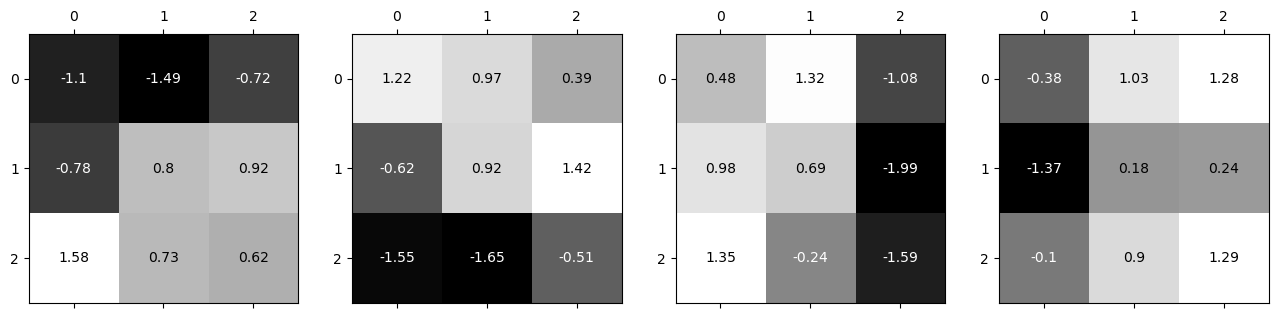

In [18]:
displayFilters(c3x3)

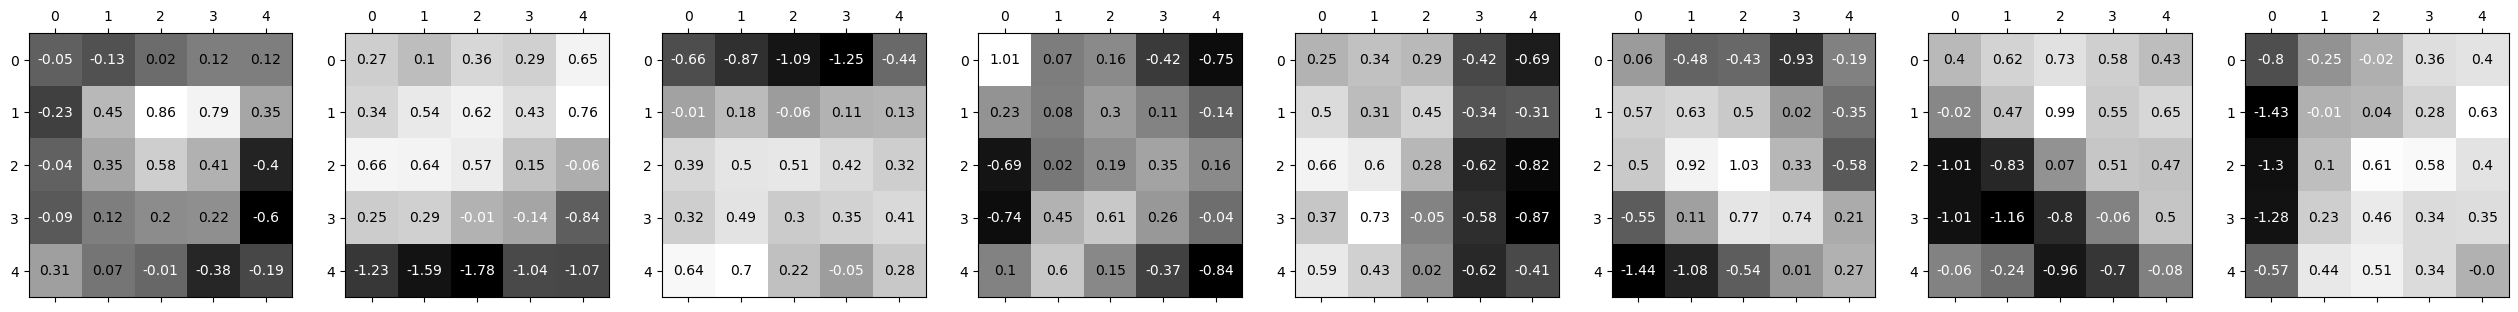

In [19]:
displayFilters(c5x5)

**Question 7:** Copy/paste here your best version of a function for correlation without normalisation.

In [43]:
def cross_correlation_without_normalisation(image, pattern, stride):
    pattern_height, pattern_width = pattern.shape[:2]

    # Make sure pattern dimensions are odd
    if pattern_height % 2 == 0:
        pattern = pattern[:-1, :]
    if pattern_width % 2 == 0:
        pattern = pattern[:, :-1]

    hmo2, wmo2 = pattern_height // 2, pattern_width // 2  # assuming mo of odd width and height

    image_height, image_width = image.shape[:2]

    result = np.zeros((image.shape[0] // stride, image.shape[1] // stride))

    for j in range(wmo2, image_width - wmo2, stride):
        for i in range(hmo2, image_height - hmo2, stride):
            roi = image[i - hmo2:i + hmo2 + 1, j - wmo2:j + wmo2 + 1]
            result[i // stride][j // stride] = np.sum(roi * pattern)

    return result

**Question 8:** Observe the results of correlation using a set of filters on a single image from the dataset.

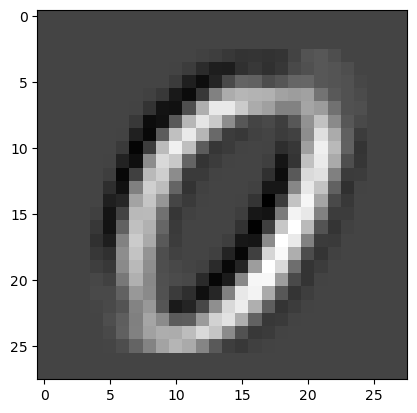

In [44]:
x_test1 = x_test[0]
x_test1 = x_test1.reshape(28, 28)
y_test1 = yTest[0]

x_test1_cc = cross_correlation_without_normalisation(x_test1, c5x5[0])
plt.imshow(x_test1_cc, cmap='gray')


**Question 9:** Similar question but adding a new parameter: the stride. Test also on a single image as you did in the previous question.

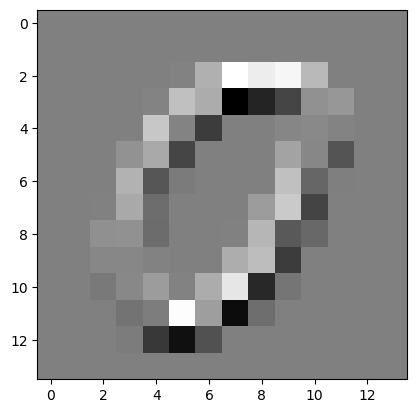

In [45]:
x_test1_cc = cross_correlation_without_normalisation(xTest[0], c3x3[0], stride=2)
plt.imshow(x_test1_cc, cmap='gray')


**Question 10:** Write a fonction that will compute all the correlations on a dataset x using a list of filters c with a stride similar on vertical and horizontal. We assume that all filters are squared filters with odd dimensions. The result is a transformed dataset with the same number of data. Each data is a vector containing all results of correlations.

In [23]:
def passeLesFiltres(x,c,stride):
    res = []
    for img in tqdm(x):
        for filter in c: 
            filtered = cross_correlation_without_normalisation(img, filter, stride)
            res.append(filtered)
    return np.array(res)

**Question 11:** Apply the previous function to the train and test dataset using the set of filters c3x3 and a stride of 3. Print the shape of the results.

In [25]:
fftrain3 = passeLesFiltres(xTrain,c3x3,3)
fftest3 = passeLesFiltres(xTest,c3x3,3)

print(fftrain3.shape)
print(fftest3.shape)

100%|██████████| 1000/1000 [00:00<00:00, 2589.97it/s]


(8000, 28, 28)
(4000, 28, 28)


**You know will use such transformed dataset in order to improve the classification results.**

## Improved classifications

Using the metrics computed on the test set, try different combinations:
- kNN (which k) or Logistic Regression
- correlation filters: c3x3, c5x5 or other filters from your imagination
- normalisation or not for the correlation
- values of strides
- removing negative values after the correlation operation
Or any other idea that you can discuss with your teachers (or in the slack channel of the course). 

Each time you obtain a better accuracy than in the previous questions, publish it in slack.

In [26]:
fftrain5 = passeLesFiltres(xTrain,c5x5,3)
fftest5 = passeLesFiltres(xTest,c5x5,3)

print(fftrain5.shape)
print(fftest5.shape)



100%|██████████| 1000/1000 [00:00<00:00, 2703.69it/s]

(16000, 28, 28)
(8000, 28, 28)
